In [1]:
import numpy as np
import openmm
import openmm.unit as unit
import openmm.app as app
from openmm import unit

from openff.toolkit import Molecule, Topology, ForceField
from openff.interchange import Interchange

import pysages
from pysages.grids import Grid
from pysages.colvars import DihedralAngle
from pysages.colvars.core import CollectiveVariable, multicomponent, build
from pysages.methods import SerialExecutor, UmbrellaIntegration
from pysages.approxfun import compute_mesh
from utils import CVLogger
import importlib

from openff.toolkit.topology import Molecule
from rdkit.Chem import Draw
import pickle

pi = np.pi

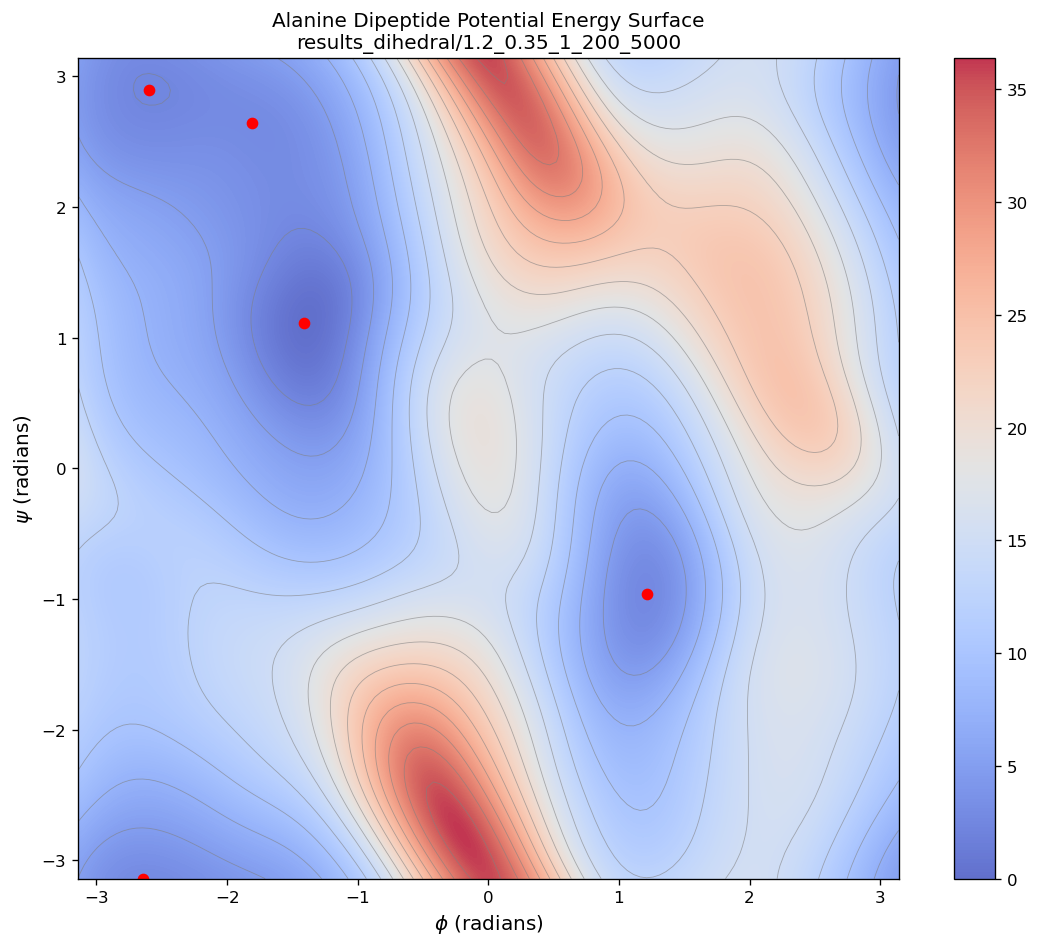

In [2]:
import matplotlib.pyplot as plt

with open(f'../metadynamics/3D/alanine_dipeptide/test/results_dihedral/1.2_0.35_1_200_5000.pkl','rb') as f:
    run_results = pickle.load(f)

fe_result = pysages.analyze(run_results)
metapotential = fe_result["metapotential"]

T = 300 * unit.kelvin
deltaT = 5000
kB = unit.BOLTZMANN_CONSTANT_kB * unit.AVOGADRO_CONSTANT_NA
kB = kB.value_in_unit(unit.kilojoules_per_mole / unit.kelvin)

plot_grid = pysages.Grid(lower=(-pi, -pi), upper=(pi, pi), shape=(128, 128), periodic=True)
xi = (compute_mesh(plot_grid) + 1) / 2 * plot_grid.size + plot_grid.lower
alpha = 1 if deltaT is None else (T.value_in_unit(unit.kelvin) + deltaT) / deltaT
kT = kB * T.value_in_unit(unit.kelvin)

A = metapotential(xi) * -alpha / kT
A = A - A.min()
A = A.reshape(plot_grid.shape).T

fig, ax = plt.subplots(dpi=120, figsize=(10, 8))
im = ax.imshow(A, interpolation="bicubic", origin="lower", extent=[-pi, pi, -pi, pi], 
               cmap='coolwarm', alpha=0.8)
contours = ax.contour(A, levels=15, linewidths=0.5, colors="grey", 
                     extent=[-pi, pi, -pi, pi], alpha=0.6)

ax.set_xlabel(r"$\phi$ (radians)", fontsize=12)
ax.set_ylabel(r"$\psi$ (radians)", fontsize=12)
ax.set_xlim(-pi, pi)
ax.set_ylim(-pi, pi)


from scipy.ndimage import minimum_filter
local_min = minimum_filter(A, size=5) == A
# Filter for significant minima (lowest 5% of energy values)
significant_minima = local_min & (A < np.percentile(A, 10))
min_rows, min_cols = np.where(significant_minima)

phi_minima = min_cols / (A.shape[1] - 1) * (2*pi) - pi
psi_minima = min_rows / (A.shape[0] - 1) * (2*pi) - pi
plt.scatter(phi_minima, psi_minima, c='red')


plt.title("Alanine Dipeptide Potential Energy Surface\nresults_dihedral/1.2_0.35_1_200_5000")
plt.colorbar(im)
plt.tight_layout()
plt.show()

In [3]:
from scipy.ndimage import minimum_filter

local_min = minimum_filter(A, size=5) == A
# Filter for significant minima (lowest 5% of energy values)
significant_minima = local_min & (A < np.percentile(A, 10))
min_rows, min_cols = np.where(significant_minima)

# Convert array indices to actual phi2, phi3 coordinates
# A is shape (128, 128) and extent is [-pi, pi, -pi, pi]
phi_minima = min_cols / (A.shape[1] - 1) * (2*pi) - pi
psi_minima = min_rows / (A.shape[0] - 1) * (2*pi) - pi

In [4]:
print(phi_minima)
print(psi_minima)

[-2.64685365  1.21211055 -1.41000615 -1.80579735 -2.59737975]
[-3.14159265 -0.96474105  1.11316275  2.64685365  2.89422315]


In [5]:
alanine_dipeptide = 'CC(=O)NC(C)C(=O)NC'
force_field = 'openff-2.0.0.offxml'

ala = Molecule.from_smiles(alanine_dipeptide, allow_undefined_stereo=True)
rdkit_mol = ala.to_rdkit()
for atom in rdkit_mol.GetAtoms():
    atom.SetProp('atomLabel', str(atom.GetIdx()))
img = Draw.MolToImage(rdkit_mol)
img.show()

ala.generate_conformers(n_conformers=1)
top = Topology.from_molecules(ala)
ff = ForceField(force_field)
inter = Interchange.from_smirnoff(force_field=ff, topology=top)

/home/xiangrui/miniconda3/envs/sim/lib/python3.12/site-packages/openff/amber_ff_ports/amber_ff_ports.py:8: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import resource_filename


In [6]:
cvs = [DihedralAngle([1,3,4,6]), DihedralAngle([3,4,6,8])]
timesteps_total = int(1e6)
k = 50
timesteps = int(timesteps_total / k)
state1 = (-1.41000615, 1.11316275)
state2 = (1.21211055, -0.96474105)
span_factor = 1
slice_num = 50
windows = []
phi_path = np.linspace(state1[0], state2[0], slice_num)
psi_path = np.linspace(state1[1], state2[1], slice_num)
for pos in np.column_stack([phi_path, psi_path]):
    windows.append((pos[0], pos[1]))

futures = importlib.import_module("mpi4py.futures")
executor = futures.MPIPoolExecutor()
        
prefix = f'results/umbrella/'
filename = f'um_{k}_{slice_num}'
output_stride = int(100)
method = UmbrellaIntegration(cvs, k, windows, output_stride)
# callback = CVLogger(log_file=f'{prefix}{filename}', log_period=output_stride)

In [7]:
def get_executor(args):
    if args.mpi:
        futures = importlib.import_module("mpi4py.futures")
        return futures.MPIPoolExecutor()
    return SerialExecutor()

def post_run_action(**kwargs):
    kwargs.get("context").saveState(f"{prefix}{filename}_{kwargs.get('replica_num')}.xml")

def generate_simulation(inter=inter, file_name=prefix+filename, output_stride=output_stride, **kwargs):
    # log info
    trj_freq = output_stride
    data_freq = output_stride

    # Integration options
    time_step = 1 * unit.femtoseconds
    temperature = 300 * unit.kelvin
    friction = 10 / unit.picoseconds

    integrator = openmm.LangevinIntegrator(temperature, friction, time_step)
    simulation = inter.to_openmm_simulation(integrator=integrator)
    simulation.context.setVelocitiesToTemperature(temperature)
    simulation.context.setPeriodicBoxVectors(
        [40.0, 0.0, 0.0] * unit.angstrom,
        [0.0, 40.0, 0.0] * unit.angstrom,
        [0.0, 0.0, 40.0] * unit.angstrom
    )

    pdb_reporter = app.PDBReporter(f"{file_name}_{kwargs.get('replica_num')}.pdb", trj_freq, enforcePeriodicBox=True)
    state_data_reporter = app.StateDataReporter(
        f"{file_name}_{kwargs.get('replica_num')}.csv",
        data_freq,
        step=True,
        potentialEnergy=True,
        kineticEnergy=True,
        temperature=True,
    )
    simulation.reporters.append(pdb_reporter)
    simulation.reporters.append(state_data_reporter)

    return simulation

In [8]:
results = pysages.run(method, generate_simulation, timesteps, executor=SerialExecutor(), post_run_action=post_run_action)

In [9]:
with open(f'{prefix}{filename}.pkl', 'wb') as f:
    pickle.dump(results, f)